In [9]:
import numpy as np
import pickle
import statistics

from xgboost import XGBClassifier
from sympy.core.numbers import igcd
from datetime import datetime

from sklearn import preprocessing
from sklearn import svm
from sklearn import preprocessing
from sklearn.ensemble import IsolationForest


from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.preprocessing import MinMaxScaler,QuantileTransformer,RobustScaler,StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import os
import time
import random
from scipy import stats

from pyod.models.hbos import HBOS
from pyod.models.cblof import CBLOF
from pyod.models.loci import LOCI
from pyod.models.xgbod import XGBOD
from pyod.models.cof import COF
from pyod.models.loda import LODA
from pyod.models.copod import COPOD
from pyod.models.sod import SOD
from pyod.models.vae import VAE
from pyod.models.lof import LocalOutlierFactor,LOF
from pyod.models.lscp import LSCP
from pyod.models.so_gaal import SO_GAAL
from pyod.models.mo_gaal import MO_GAAL
from pyod.models.iforest import IForest
from pyod.models.ocsvm import OCSVM
from pyod.models.auto_encoder import AutoEncoder

from keras.models import Sequential
from keras import layers
from keras.models import Model, load_model
from keras.layers import Input, Dense, Dropout,LSTM, Conv1D, MaxPooling1D, AveragePooling1D, Flatten,Reshape,UpSampling1D
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from keras.optimizers import adam_v2
from tensorflow.keras.optimizers import SGD
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from sklearn.manifold import TSNE
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [10]:
#Generates the autoencoder 
def gen_autoencoder(X_train,encoding_dim):
    
    input_dim = X_train.shape[1] # the # features

    input_layer = Input(shape=(input_dim, ))
    hidden = Dense(encoding_dim[0], activation="relu")(input_layer)
    for n_neurons in encoding_dim[1:]:
        hidden = Dense(n_neurons, activation="relu")(hidden)#, activity_regularizer=regularizers.l1(10e-5))(input_layer)    
        #hidden = Dropout(0.5)(hidden)
    
    hidden = Dense(input_dim)(hidden)
    
    autoencoder = Model(inputs=input_layer, outputs=hidden)
    opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
    autoencoder.compile(loss='mean_squared_error', optimizer = opt,metrics=['acc'])
    return autoencoder

#Get anomaly threshold from "autoencoder" setting the threshold in Q1,Q3+-1.5IQR
def get_threshold_mse_iqr(autoencoder,train_data):
    train_predicted = autoencoder.predict(train_data)
    mse = np.mean(np.power(train_data - train_predicted, 2), axis=1)
    iqr = np.quantile(mse,0.75) - np.quantile(mse, 0.25)
    up_bound = np.quantile(mse,0.75) + 1.5*iqr
    bottom_bound = np.quantile(mse,0.25) - 1.5*iqr
    thres = [up_bound,bottom_bound]
    return thres

#Get anomaly threshold from "autoencoder" setting the threshold in "train_data" using "outlier_percentage"
def get_threshold_mse_percentage(autoencoder,train_data,outlier_percentage):
    train_predicted = autoencoder.predict(train_data)
    mse = np.mean(np.power(train_data - train_predicted, 2), axis=1)
    thresh = np.quantile(mse, 1-outlier_percentage)
    return thresh

#Predict outliers in "df" using "autoencoder" model and "threshold_mse" as anomaly limit
def detect_outliers(autoencoder, df, threshold_mse):
    if(len(threshold_mse)==2):
        return detect_outliers_range(autoencoder, df, threshold_mse)
    pred=autoencoder.predict(df)
    mse = np.mean(np.power(df - pred, 2), axis=1)
    #plt.hist(mse, bins=100)
    #plt.show()
    outliers = [np.array(mse) < threshold_mse]
    return outliers

def detect_outliers_range(autoencoder, df, threshold_mse):
    pred=autoencoder.predict(df)
    mse = np.mean(np.power(df - pred, 2), axis=1)
    up_bound = threshold_mse[0]
    bottom_bound = threshold_mse[1]
    outliers = [(np.array(mse) < up_bound)&(np.array(mse) > bottom_bound)]
    return outliers
    

In [11]:
def plot_hist(data):
    fig,ax = plt.subplots()
    fig.set_size_inches(10.5, 7.5, forward=True)
    plt.hist(data, bins = 1000)
    plt.show()

In [12]:
# Data load
df_0=pd.read_csv("../../data/rp3_normal_0.csv")
df_1=pd.read_csv("../../data/rp3_normal_1.csv")
df_2=pd.read_csv("../../data/rp3_normal_2.csv")
df_3=pd.read_csv("../../data/rp3_normal_3.csv")
df_4=pd.read_csv("../../data/rp3_normal_4.csv")
df_5=pd.read_csv("../../data/rp3_normal_5.csv")
df_6=pd.read_csv("../../data/rp3_normal_6.csv")
df_mix=pd.read_csv("../../data/rp3_normal_all.csv")

In [13]:
df_0.head()

,time,timestamp,seconds,connectivity,alarmtimer:alarmtimer_fired,alarmtimer:alarmtimer_start,block:block_bio_backmerge,block:block_bio_remap,block:block_dirty_buffer,block:block_getrq,...,writeback:sb_clear_inode_writeback,writeback:wbc_writepage,writeback:writeback_dirty_inode,writeback:writeback_dirty_inode_enqueue,writeback:writeback_dirty_page,writeback:writeback_mark_inode_dirty,writeback:writeback_pages_written,writeback:writeback_single_inode,writeback:writeback_write_inode,writeback:writeback_written
0,5.01067,1615419355692,5.010671,1,0,0,0,4,0,4,...,4,10,30,0,0,30,1,3,2,3
1,10.02160,1615419367473,5.010927,1,0,0,5,8,5,3,...,1,0,25,1,5,30,1,2,2,3
2,15.03190,1615419379525,5.010342,1,0,0,5,8,5,3,...,1,0,4,1,5,9,1,2,2,3
3,20.04150,1615419392089,5.009618,1,0,0,5,8,5,3,...,1,0,3,1,5,8,1,2,2,3
4,25.05200,1615419404359,5.010503,1,0,0,5,8,5,3,...,1,0,26,1,5,31,1,2,2,3


In [16]:
print(df_0.shape[1])
df_0.columns.tolist()

82


['time',
 'timestamp',
 'seconds',
 'connectivity',
 'alarmtimer:alarmtimer_fired',
 'alarmtimer:alarmtimer_start',
 'block:block_bio_backmerge',
 'block:block_bio_remap',
 'block:block_dirty_buffer',
 'block:block_getrq',
 'block:block_touch_buffer',
 'block:block_unplug',
 'cachefiles:cachefiles_create',
 'cachefiles:cachefiles_lookup',
 'cachefiles:cachefiles_mark_active',
 'clk:clk_set_rate',
 'cpu-migrations',
 'cs',
 'dma_fence:dma_fence_init',
 'fib:fib_table_lookup',
 'filemap:mm_filemap_add_to_page_cache',
 'gpio:gpio_value',
 'ipi:ipi_raise',
 'irq:irq_handler_entry',
 'irq:softirq_entry',
 'jbd2:jbd2_handle_start',
 'jbd2:jbd2_start_commit',
 'kmem:kfree',
 'kmem:kmalloc',
 'kmem:kmem_cache_alloc',
 'kmem:kmem_cache_free',
 'kmem:mm_page_alloc',
 'kmem:mm_page_alloc_zone_locked',
 'kmem:mm_page_free',
 'kmem:mm_page_pcpu_drain',
 'mmc:mmc_request_start',
 'net:net_dev_queue',
 'net:net_dev_xmit',
 'net:netif_rx',
 'page-faults',
 'pagemap:mm_lru_insertion',
 'preemptirq:irq_

In [7]:
# Filter vectors according to the timestamps
df_0 = df_0.loc[(df_0['timestamp'] >= 1615419435000) & (df_0['timestamp'] <= 1615451520000)]
df_1 = df_1.loc[(df_1['timestamp'] >= 1615925651000) & (df_1['timestamp'] <= 1615929569000)]
df_2 = df_2.loc[(df_2['timestamp'] >= 1615930017000) & (df_2['timestamp'] <= 1615933673000)]
df_3 = df_3.loc[(df_3['timestamp'] >= 1615969307000) & (df_3['timestamp'] <= 1615972800000)]
df_4 = df_4.loc[(df_4['timestamp'] >= 1615974874000) & (df_4['timestamp'] <= 1615978500000)]
df_5 = df_5.loc[(df_5['timestamp'] >= 1615978899000) & (df_5['timestamp'] <= 1615982700000)]
df_6 = df_6.loc[(df_6['timestamp'] >= 1615989015000) & (df_6['timestamp'] <= 1615992622000)]
df_mix = df_mix.loc[(df_mix['timestamp'] >= 1615996500000) & (df_mix['timestamp'] <= 1616005200000)]

In [6]:
#df_0.describe()

In [17]:
df = pd.concat([df_0, df_1, df_2, df_3, df_4, df_5, df_6, df_mix])
df.head(10)

,time,timestamp,seconds,connectivity,alarmtimer:alarmtimer_fired,alarmtimer:alarmtimer_start,block:block_bio_backmerge,block:block_bio_remap,block:block_dirty_buffer,block:block_getrq,...,writeback:sb_clear_inode_writeback,writeback:wbc_writepage,writeback:writeback_dirty_inode,writeback:writeback_dirty_inode_enqueue,writeback:writeback_dirty_page,writeback:writeback_mark_inode_dirty,writeback:writeback_pages_written,writeback:writeback_single_inode,writeback:writeback_write_inode,writeback:writeback_written
0,5.01067,1615419355692,5.010671,1,0,0,0,4,0,4,...,4,10,30,0,0,30,1,3,2,3
1,10.02160,1615419367473,5.010927,1,0,0,5,8,5,3,...,1,0,25,1,5,30,1,2,2,3
2,15.03190,1615419379525,5.010342,1,0,0,5,8,5,3,...,1,0,4,1,5,9,1,2,2,3
3,20.04150,1615419392089,5.009618,1,0,0,5,8,5,3,...,1,0,3,1,5,8,1,2,2,3
4,25.05200,1615419404359,5.010503,1,0,0,5,8,5,3,...,1,0,26,1,5,31,1,2,2,3
5,30.06190,1615419416476,5.009887,1,0,0,5,8,5,3,...,1,0,29,1,5,34,1,2,2,3
6,35.07300,1615419428747,5.011101,1,0,0,5,8,5,3,...,1,0,24,1,5,29,1,2,2,3
7,40.08340,1615419440540,5.010411,1,0,0,5,8,5,3,...,1,0,4,1,5,9,1,2,2,3
8,45.09450,1615419452291,5.011067,1,0,0,6,10,6,4,...,1,0,3,1,6,9,1,2,2,3
9,50.12030,1615419464012,5.025842,1,0,0,5,8,5,3,...,1,0,6,1,5,11,1,2,2,3


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5637 entries, 0 to 770
Data columns (total 82 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   time                                     5637 non-null   float64
 1   timestamp                                5637 non-null   int64  
 2   seconds                                  5637 non-null   float64
 3   connectivity                             5637 non-null   int64  
 4   alarmtimer:alarmtimer_fired              5637 non-null   int64  
 5   alarmtimer:alarmtimer_start              5637 non-null   int64  
 6   block:block_bio_backmerge                5637 non-null   int64  
 7   block:block_bio_remap                    5637 non-null   int64  
 8   block:block_dirty_buffer                 5637 non-null   int64  
 9   block:block_getrq                        5637 non-null   int64  
 10  block:block_touch_buffer                 5637 non

In [9]:
df = df.loc[(df['connectivity']==1)]

In [10]:
# Remove columns with constant values
df=df.loc[:, (df != df.iloc[0]).any()]

In [31]:
pd.set_option('display.max_rows', 83)
df.describe().transpose()[["mean", "std", "min", "50%", "max"]]

,mean,std,min,50%,max
time,3.925744e+03,3.943970e+03,1.503360e+01,1.904390e+03,1.339810e+04
timestamp,1.615705e+12,2.698320e+08,1.615419e+12,1.615926e+12,1.616005e+12
seconds,5.011841e+00,9.418594e-03,5.008997e+00,5.010565e+00,5.285210e+00
connectivity,9.973846e-01,5.107840e-02,0.000000e+00,1.000000e+00,1.000000e+00
alarmtimer:alarmtimer_fired,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
alarmtimer:alarmtimer_start,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
block:block_bio_backmerge,1.723893e+00,2.636197e+00,0.000000e+00,0.000000e+00,5.900000e+01
block:block_bio_remap,2.640575e+00,3.841022e+00,0.000000e+00,0.000000e+00,7.200000e+01
block:block_dirty_buffer,4.165328e+00,1.479337e+02,0.000000e+00,0.000000e+00,1.052100e+04
block:block_getrq,9.088362e-01,1.395026e+00,0.000000e+00,0.000000e+00,2.700000e+01


In [22]:
print(df.shape)

(5353, 82)


In [18]:
df.drop(['time','timestamp'],axis=1,inplace=True)

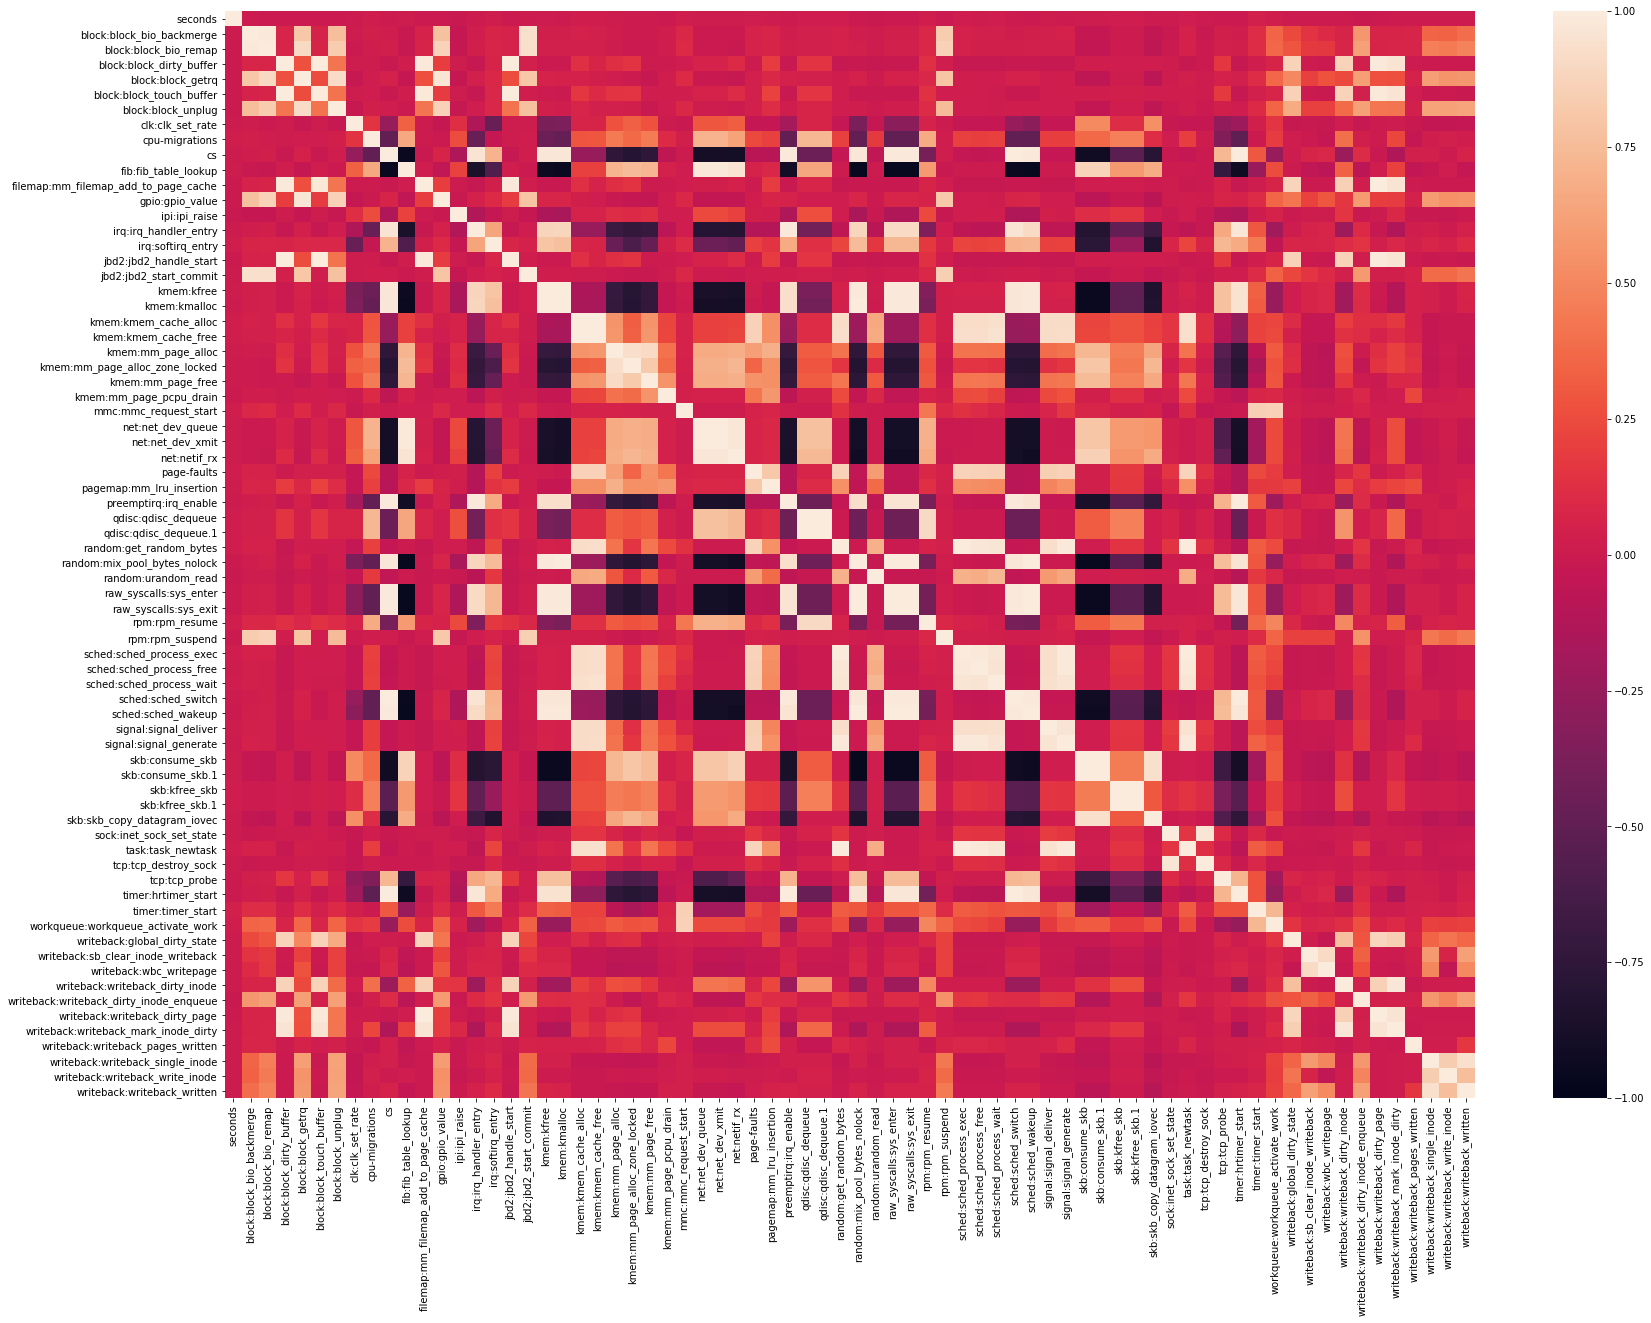

In [13]:
# Calculate the correlation between features

corr = df.corr()
f, ax = plt.subplots(figsize=(28, 20))
sn.heatmap(corr,vmin=-1.0,vmax=1.0)

In [14]:
# Split dataset in training and testing
X_train, X_test = train_test_split(df, test_size=0.10, random_state=42)
X_train.shape

(4805, 72)

In [15]:
#Save selected features
feat_list=X_train.columns

In [16]:
#Feature scaling

# Min_Max_Scaler normalization
#scaler = MinMaxScaler().fit(X_train)
#scaler = QuantileTransformer(n_quantiles=1000,random_state=42).fit(X_train)
#scaler = RobustScaler().fit(X_train)
scaler= StandardScaler().fit(X_train)
# Transform training set
X_train = scaler.transform(X_train)
# Transform test set
X_test = scaler.transform(X_test)

In [17]:
# Different models

#clf = IsolationForest(random_state=42, contamination=0.2)

"""detector_list=[AutoEncoder([32,16,32], hidden_activation='relu',epochs=20,contamination=0.1),
                LOF(contamination=0.1,n_neighbors=25), COPOD(contamination=0.1),
                IForest(random_state=42,contamination=0.1), CBLOF(n_clusters=20,contamination=0.1),
                HBOS(n_bins=100,contamination=0.1), LODA(n_bins=100,n_random_cuts=100,contamination=0.1)]"""
#clf = LSCP(detector_list)
#clf = AutoEncoder([16], hidden_activation='relu',epochs=20,contamination=0.2,dropout_rate=0.0,preprocessing=True)
#clf = LOF(contamination=0.05,n_neighbors=50)
#clf = CBLOF(n_clusters=20,contamination=0.2)
#clf = VAE(encoder_neurons=[32,16],decoder_neurons=[16,32],latent_dim=2,epochs=50,contamination=0.05,verbose=1)
#clf = LODA(n_bins=100,n_random_cuts=100,contamination=0.2)
#clf = COPOD(contamination=0.2)
#clf = HBOS(n_bins=100,contamination=0.2)
#clf = SO_GAAL(contamination=0.2)
#clf = MO_GAAL(contamination=0.2)
#clf = OCSVM(kernel='rbf',gamma=0.0001, nu=0.3)


"detector_list=[AutoEncoder([32,16,32], hidden_activation='relu',epochs=20,contamination=0.1),\n                LOF(contamination=0.1,n_neighbors=25), COPOD(contamination=0.1),\n                IForest(random_state=42,contamination=0.1), CBLOF(n_clusters=20,contamination=0.1),\n                HBOS(n_bins=100,contamination=0.1), LODA(n_bins=100,n_random_cuts=100,contamination=0.1)]"

In [18]:
# Model training

#clf.fit(X_train)

In [19]:
# Model evaluation with good behaviour
#pred=clf.predict(X_test)
#unique_elements, counts_elements = np.unique(pred, return_counts=True)
#print("\t",unique_elements,"    ",counts_elements)

In [20]:
#MANUAL AUTOENCODER BUILD AND TRAIN
autoencoder=gen_autoencoder(X_train,[32,16,32])
es = EarlyStopping(monitor='val_loss', mode='min',patience=20)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)
history = autoencoder.fit(X_train, X_train,epochs=2000,
                    batch_size=16,
                    shuffle=True,
                    validation_split=0.2,
                    verbose=1,
                    callbacks=[es, mc]).history
autoencoder = load_model('best_model.h5')

Train on 3844 samples, validate on 961 samples
Epoch 1/2000
3844/3844 [==============================] - 1s 321us/step - loss: 0.6943 - acc: 0.0200 - val_loss: 0.3522 - val_acc: 0.0229
Epoch 2/2000
3844/3844 [==============================] - 1s 167us/step - loss: 0.4060 - acc: 0.0918 - val_loss: 0.2613 - val_acc: 0.1696
Epoch 3/2000
3844/3844 [==============================] - 1s 152us/step - loss: 0.3444 - acc: 0.1917 - val_loss: 0.2197 - val_acc: 0.2393
Epoch 4/2000
3844/3844 [==============================] - 1s 158us/step - loss: 0.3084 - acc: 0.2336 - val_loss: 0.2148 - val_acc: 0.2778
Epoch 5/2000
3844/3844 [==============================] - 1s 176us/step - loss: 0.2947 - acc: 0.2508 - val_loss: 0.1918 - val_acc: 0.2820
Epoch 6/2000
3844/3844 [==============================] - 1s 168us/step - loss: 0.2336 - acc: 0.3075 - val_loss: 0.2086 - val_acc: 0.3476
Epoch 7/2000
3844/3844 [==============================] - 1s 144us/step - loss: 0.2030 - acc: 0.3533 - val_loss: 0.1612 - val

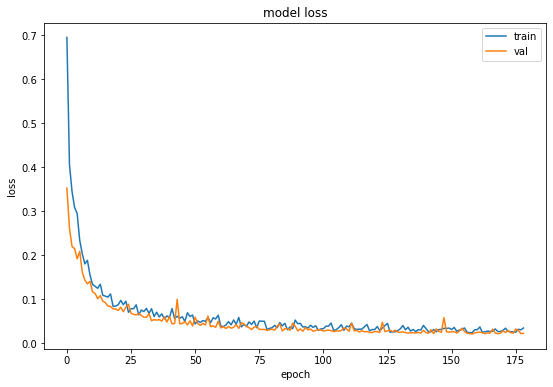

In [21]:
plt.figure(figsize=(9,6))
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [22]:
#GET ANOMALY THRESHOLD
#autoencoder = load_model('best_model.h5')
#thresh = get_threshold_mse_percentage(autoencoder,X_train,0.1)
thresh = get_threshold_mse_iqr(autoencoder,X_train)
print(thresh)

[0.035828258009633976, -0.01050782841793263]


In [23]:
# Predict Anomalies contained in the normal behaviour
mad_outliers = detect_outliers(autoencoder, X_test, thresh)
unique_elements, counts_elements = np.unique(mad_outliers, return_counts=True)
print("\t",unique_elements,"    ",counts_elements)

	 [False  True]      [ 35 499]


In [24]:
##### Attack 1: SENDING FAKE PSD VALUES ####

In [25]:
df_fakepsd=pd.read_csv("./Datasets/Rp3_3rd_capture/rp3_fakePSD.csv")

In [26]:
df_fakepsd_1 = df_fakepsd.loc[(df_fakepsd['timestamp'] >= 1615452439000) & (df_fakepsd['timestamp'] <= 1615478400000)]
df_fakepsd_2 = df_fakepsd.loc[(df_fakepsd['timestamp'] >= 1615479600000) & (df_fakepsd['timestamp'] <= 1615485600000)]

df_fakepsd = pd.concat([df_fakepsd_1, df_fakepsd_2])
df_fakepsd.drop(['time','timestamp'],axis=1,inplace=True)

In [27]:
df_fakepsd = df_fakepsd.loc[(df_fakepsd['connectivity']==1)]

In [28]:
df_fakepsd = df_fakepsd[df_fakepsd.columns.intersection(feat_list)]

In [29]:
df_fakepsd = scaler.transform(df_fakepsd)

In [30]:
#pred=clf.predict(df_fakepsd)
#unique_elements, counts_elements = np.unique(pred, return_counts=True)
#print("\t",unique_elements,"    ",counts_elements)

In [31]:
mad_outliers = detect_outliers(autoencoder, df_fakepsd, thresh)
unique_elements, counts_elements = np.unique(mad_outliers, return_counts=True)
print("\t",unique_elements,"    ",counts_elements)

	 [False]      [2679]


In [32]:
##### Attack 2: SENDING OUT PSD VALUES #### 

In [33]:
df_sendout=pd.read_csv("./Datasets/Rp3_3rd_capture/rp3_sendOut.csv")

In [34]:
df_sendout_1 = df_sendout.loc[(df_sendout['timestamp'] >= 1615795500000) & (df_sendout['timestamp'] <= 1615805280000)]
df_sendout_2 = df_sendout.loc[(df_sendout['timestamp'] >= 1615806000000) & (df_sendout['timestamp'] <= 1615809600000)]

df_sendout = pd.concat([df_sendout_1, df_sendout_2])
df_sendout.drop(['time','timestamp'],axis=1,inplace=True)

In [35]:
df_sendout = df_sendout.loc[(df_sendout['connectivity']==1)]

In [36]:
df_sendout = df_sendout[df_sendout.columns.intersection(feat_list)]

In [37]:
df_sendout = scaler.transform(df_sendout)

In [38]:
#pred=clf.predict(df_fakepsd)
#unique_elements, counts_elements = np.unique(pred, return_counts=True)
#print("\t",unique_elements,"    ",counts_elements)

In [39]:
mad_outliers = detect_outliers(autoencoder, df_sendout, thresh)
unique_elements, counts_elements = np.unique(mad_outliers, return_counts=True)
print("\t",unique_elements,"    ",counts_elements)

	 [False]      [1122]


In [40]:
##### Attack 3: WRITE #### PRIVACY LEAKAGE

In [41]:
df_write=pd.read_csv("./Datasets/Rp3_3rd_capture/rp3_write.csv")

In [42]:
df_write = df_write.loc[(df_write['timestamp'] >= 1615834554000) & (df_write['timestamp'] <= 1615843200000)]

df_write.drop(['time','timestamp'],axis=1,inplace=True)

In [43]:
df_write = df_write.loc[(df_write['connectivity']==1)]

In [44]:
df_write = df_write[df_write.columns.intersection(feat_list)]

In [45]:
df_write = scaler.transform(df_write)

In [46]:
#pred=clf.predict(df_fakepsd)
#unique_elements, counts_elements = np.unique(pred, return_counts=True)
#print("\t",unique_elements,"    ",counts_elements)

In [47]:
mad_outliers = detect_outliers(autoencoder, df_write, thresh)
unique_elements, counts_elements = np.unique(mad_outliers, return_counts=True)
print("\t",unique_elements,"    ",counts_elements)

	 [False]      [708]


In [48]:
##### Attack 4: ADDING RANDOM NOISE TO PSD VALUES ####

In [49]:
# Data load
df_random=pd.read_csv("./Datasets/Rp3_3rd_capture/rp3_random.csv")

In [50]:
# Remove columns with constant values
df_random = df_random.loc[(df_random['connectivity']==1)]

In [51]:
# Filter vectors according to the timestamps
df_random_new = df_random.loc[(df_random['timestamp'] >= 1615913848000) & (df_random['timestamp'] <= 1615922405000)]

df_random_new.drop(['time','timestamp'],axis=1,inplace=True)

/home/pedromiguel/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [52]:
X_outliers6=df_random_new[df_random_new.columns.intersection(feat_list)]

In [53]:
# Transform outliers set
X_outliers6 = scaler.transform(X_outliers6)

In [54]:
#Outliers with manual autoencoder
mad_outliers = detect_outliers(autoencoder, X_outliers6, thresh)
unique_elements, counts_elements = np.unique(mad_outliers, return_counts=True)
print("\t",unique_elements,"    ",counts_elements)

	 [False]      [717]


In [55]:
##### Attack 5: EXCHANGE PSD VALUES OF TWO FREQUENCY BANDS ####
# Freq bands 90Mhz - [300Mhz - 1Ghz]

In [56]:
# Data load
df_exchange2=pd.read_csv("./Datasets/Rp3_3rd_capture/rp3_exchange.csv")

In [57]:
# Remove columns with constant values
df_exchange2 = df_exchange2.loc[(df_exchange2['connectivity']==1)]

In [58]:
# Filter vectors according to the timestamps
df_exchange2 = df_exchange2.loc[(df_exchange2['timestamp'] >= 1616585145000) & (df_exchange2['timestamp'] <= 1616589463000)]

df_exchange2.drop(['time','timestamp'],axis=1,inplace=True)

In [59]:
X_outliers9=df_exchange2[df_exchange2.columns.intersection(feat_list)]

In [60]:
# Transform outliers set
X_outliers9 = scaler.transform(X_outliers9)

In [61]:
#Outliers with manual autoencoder
mad_outliers = detect_outliers(autoencoder, X_outliers9, thresh)
unique_elements, counts_elements = np.unique(mad_outliers, return_counts=True)
print("\t",unique_elements,"    ",counts_elements)

	 [False  True]      [231 116]


In [62]:
##### Attack 6: Hide a transmission ####
# 200Mhz - 250Mz

In [63]:
# Data load
df_hide=pd.read_csv("./Datasets/Rp3_3rd_capture/rp3_hide.csv")

In [64]:
# Remove columns with constant values
df_hide = df_hide.loc[(df_hide['connectivity']==1)]

In [65]:
# Filter vectors according to the timestamps
df_hide = df_hide.loc[(df_hide['timestamp'] >= 1616672277000) & (df_hide['timestamp'] <= 1616676574000)]

df_hide.drop(['time','timestamp'],axis=1,inplace=True)

In [66]:
X_outliers10 = df_hide[df_hide.columns.intersection(feat_list)]

In [67]:
# Transform outliers set
X_outliers10 = scaler.transform(X_outliers10)

In [68]:
#Outliers with manual autoencoder
mad_outliers = detect_outliers(autoencoder, X_outliers10, thresh)
unique_elements, counts_elements = np.unique(mad_outliers, return_counts=True)
print("\t",unique_elements,"    ",counts_elements)

	 [False  True]      [ 37 318]
